# Product Image Similarity
In this notebook, we will develop a model that takes an image as input, and finds closely related product images based on that. "Closely related," in this context, means images that "look" similar to the input image.

##### Overview of the process:
1. We will create a generator to hold the file paths of all the images in our dataset. We will then use this generator to explore our dataset, and later, feed it into our model.
2. We won't be "training" a new model; we'll just use an existing convolutional network (ResNet) and load its pre-trained weights. What we will be doing, however, is feeding the images in our dataset to get the images' embedding vectors.
3. When a user uploads an image and tries to find the most similar product image(s) from our dataset, we will need a mechanism to compare the uploaded image with all/most of the images in our dataset. The naive solution is to create a large table with the embeddings of every image and then iterating through the entire list. However, because websites have lots of product images, this is not scalable. The Amazon-Berkley Objects dataset itself contains over 398,000 images, and real-world cases will be much larger. So, iterating through the entire list of images every time we want to find similar products/images is very inefficient. Instead, we will use locality sensitive hashing to find the k-approximate nearest neighbors -- i.e. "similar" images. This will return relatively good results (but not the absolute best/closest matches) in an efficient (fast) manner.
4. While we are calculating the images' embedding vectors, we will also populate a lookup table (an SQL database) that references the image ID with the location of the image.
5. Finally, we will create a prediction function that returns a list of similar images for the given input. We'll then test our model on a few example product images to ensure it's working as expected.


In [1]:
# Import libraries:

# Standard lib:
import glob
import sqlite3

# ML/data science libraries:
import numpy as np
from annoy import AnnoyIndex

# TenserFlow/Keras classes:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalMaxPool2D

# Plotting and imaging:
import cv2
import matplotlib.pyplot as plt

2022-06-09 10:57:50.260070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 10:57:50.260088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploring the Data:
We'll first create a generator that returns the file paths of all the images in our dataset. Then we'll take a look at a typical product image.

N.b. we don't need to shuffle the data since we're not doing any training.

In [2]:
def get_file_paths():
    """ Create generator of all image file paths.

    TODO: You will want to change the `path_name` to your specific dataset/location.

    :return {generator}
    """

    path_name = '../data/amazon-berkley-objects/**/*.jpg'

    # We could also have used `pathlib.Path().glob()`, but that returns a POSIX path rather than str:
    return glob.iglob(path_name, recursive=True)

file_paths = get_file_paths()

AxesImage(54,36;334.8x217.44)


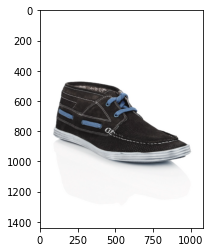

In [3]:
example_img = cv2.imread(next(file_paths))
print(plt.imshow(example_img))

# We need to reset the generator (since we used `next` to step through the iterator):
file_paths = get_file_paths()

## Load ResNet Model:
Since we only need to generate the embedding vectors, we can make use of the well-known [ResNet model](https://arxiv.org/abs/1512.03385). ResNet is [already included in Keras/TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2), and we can load pre-trained weights from ImageNet. In other words, we don't need to create a new model from scratch, and we don't need to do any training. We will remove the final couple layers in the network (i.e. the fully connected layer and the layer before that) -- these will later be replaced with a global max pooling layer, which is used for feature extraction.

In [4]:
# Constants:
# The model expects these image dimensions:
IMG_HEIGHT  = 224
IMG_WIDTH   = 224

# N.b. we could have passed the `pooling` arg when instantiating the model; however, we want to see
# the model summary before and after adding a global pooling layer, so we'll manually add that layer in the next step:
resnet_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
resnet_model.trainable = False

resnet_model.summary()

2022-06-09 10:57:52.510736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 10:57:52.510760: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 10:57:52.510775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ogedei): /proc/driver/nvidia/version does not exist
2022-06-09 10:57:52.510924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [5]:
# Update the model by adding a global max pooling layer:
# In essence, we replaced the last couple layers of the original ResNet model with a layer that outputs the embedding/features of the image.
# Recall that global pooling always reduces the output to be shape 1 x 1 x channels; essentially, outputting a layer of feature-maps.
model = Sequential([
    resnet_model,
    GlobalMaxPool2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


In [6]:
# Save the model:

# N.b. we need to specify model version as the file directory, otherwise TensorFlow Serving will
# throw an error that there aren't any servable model versions: <https://stackoverflow.com/q/45544928>:
MODEL_VERSION = 4
model.save(f'../models/resnet_similarity/{MODEL_VERSION}')

INFO:tensorflow:Assets written to: ../models/resnet_similarity/4/assets


INFO:tensorflow:Assets written to: ../models/resnet_similarity/4/assets


**Aside:** if we didn't specify `include_top=False` in `resnet_model` from the previous two cells,
we could alternatively have created a new model and get the last 3rd to last layer:
```
resnet_model_ = ResNet50V2(weights='imagenet')
```

This would, however, result in the exact same model:
```
feature_extraction_model = Model(
    name='ResNet50V2_ExtractFeature',
    inputs=resnet_model_.inputs,
    outputs=resnet_model_.get_layer('post_relu').output
)
```

## Image processing:
We'll create a helper function that processes images to something that can be fed into the model (i.e. resize and scale the image). We'll also create a function for feature extraction.

In [7]:
def process_image(img: np.ndarray):
    """ Pre-process images before feeding to model.

    Resizes image, scales (/255), and expands array dimension. The model requires specific input dimensions (shape),
    therefore resizing and adding dimension is necessary. Scaling improves performance.
    TODO: ideally, we should use standard deviation and mean of dataset instead of simply dividing by 255.

    :param img: An image file represented as a Numpy array.
    :return {np.ndarray}: A processed image.
    """

    # When serving (via TensorFlow Serving), the model signature expects float type as input (enter `saved_model_cli show`
    # in command line for details), but since cv2 reads images as float64, we need to convert it to float32. If we didn't cast the array,
    # we would get this error: `Expects arg[0] to be float but double is provided`. N.b. np.float64 and np.float32 correspond to double
    # and float types, respectively (in Java, C++, etc.); hence the error message, and reason for casting to float32.
    # N.b. this isn't an issue during development/training.
    processed_img = np.float32(img)

    # See comparison of different interpolation methods: <https://chadrick-kwag.net/cv2-resize-interpolation-methods/>
    processed_img = cv2.resize(processed_img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

    # We can use TF's ResNet `preprocess_input`:
    # <https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input>; however, because
    # the datasets are quite different, it might do more harm than good <https://stackoverflow.com/a/58250681>; we can
    # therefore, simply divide by 255:
    processed_img = processed_img / 255

    # ResNet model expects input shape (batch_size, img_height, img_width, channels); therefore, we need to add
    # batch_size dimension:
    processed_img = np.expand_dims(processed_img, axis=0)
    return processed_img


def get_embedding(file_path: str):
    """ Get the embedding vector of a given image.

    :param file_path: File location of the image.
    :return {np.ndarray}: The embedding vector (extracted features) of the image after it goes through the network.
    """

    img = cv2.imread(file_path)
    img = process_image(img)
    embedding = model.predict(img)
    embedding = np.squeeze(embedding)  # Ensure output is 1D array

    return embedding

## Setup lookup table for product images

We will be using the [Annoy library](https://github.com/spotify/annoy) for finding similar images (approximate nearest neighbors). However, the library returns the _image ID_ of the closest matches. So, in order to display the matches, we need a reference table to look up the IDs we get from Annoy.

In [8]:
def get_db_connection():
    """ Opens a database connection pool.

    Note: the DB path is hard-coded; you might want to change the path to a different location.

    :return: A connection pool
    """

    conn = sqlite3.connect('../data/database.db')
    conn.row_factory = sqlite3.Row
    return conn

In [9]:
# Create a new table:
conn_ = get_db_connection()
cur = conn_.cursor()
cur.execute("""
    CREATE TABLE products (
        id INTEGER PRIMARY KEY UNIQUE,
        file_path TEXT NOT NULL
    )
""")
conn_.commit()
conn_.close()

## Calculate the embedding vectors and k-approximate-nearest-neighbor index:
We will set up locality sensitive hashing to make our predictions more efficient. According to the Annoy documentation, there's a trade-off between the number of hyperplanes (`n_trees` arg) and the file size of the Annoy index. However, upon testing different values myself, I didn't notice much difference -- the size of the index file was pretty similar for this use-case.

##### Deciding on the number of hyperplanes when working on locality sensitive hashing:
The Amazon Berkeley Objects (ABO) Dataset has more than 398,000 images.
If we want each bucket to have 50 items, then $\frac{398,000}{50}=7,960$ buckets.
Each hyperplane divides the space into 2. So, $2^{n}=7,960 \therefore n = \log_{2}7,960 \approx 13$. Thus, we need 13 hyperplanes per instance.

In [10]:
NUM_HYPERPLANES = 13
# The last layer in model is the embedding vector, so we can grab the shape of that:
VECTOR_DIM = model.get_layer('global_max_pooling2d').output.shape[1] # Each embedding is length 2048

We will iterate through the entire dataset of images (from the generator we created earlier), simultaniously saving the embedding in the Annoy index and also saving the image file path in the lookup table:

In [11]:
%%time

# See Annoy docs: <https://github.com/spotify/annoy>
annoy_ = AnnoyIndex(VECTOR_DIM, 'angular')

# Open connection before for loop to reduce the overhead of opening and closing connection after every iteration in loop:
conn_ = get_db_connection()
cur = conn_.cursor()

# TODO: can we optimize/speed-up this, perhaps via batch processing?
for i, file_path_ in enumerate(file_paths):
    embedding_ = get_embedding(file_path_)
    annoy_.add_item(i, embedding_)

    # Add file path to db:
    cur.execute("INSERT INTO products (id, file_path) VALUES (?, ?)", (i, file_path_))

# Committing after each insertion will be safer than committing everything at once,
# but if any of the transactions fail during the loop, we'll have to start over anyway;
# so, we commit outside the loop, which is faster:
conn_.commit()
conn_.close()

1/1 [==============================] - 0s 82ms/step
CPU times: user 29min 40s, sys: 39.2 s, total: 30min 19s
Wall time: 9min 32s


In [12]:
# Build and save Annoy index:
annoy_.build(NUM_HYPERPLANES)
annoy_.save('../data/annoy_index/img_embedding.ann')

True

## Find Similar Images:
We now need to create a few functions to find similar images and then display them.

In [13]:
def query_product_by_id(id: int, cursor):
    """ Fetch SQL row object from db.

    Remember that we created a "dictionary cursor" (therefore we need to use subscript the get the column).

    :param id:
    :param cursor:
    :return {sqlite3.Row}
    """

    return cursor.execute('SELECT * FROM products WHERE id=?', (id,)).fetchone()

In [22]:
def find_similar_images(img_path: str, num_results: int = 5):
    """ Get N similar images.

    :param img_path: File path of source image. Function finds similar product images based on this source image.
    :param num_results: The number of similar items we want to return. E.g. if set to 5, the function will return
        the closest 5 images.
    :return {list}: A list of file paths (strings).
    """

    # N.b. if user searches for an image that already exists in database,
    # we DO want to return the exact same image; it's not a duplicate result.

    # Load single image, process, and get embedding:
    target_embedding = get_embedding(img_path)

    ids_of_matches = annoy_.get_nns_by_vector(target_embedding, num_results)

    # Get file paths from lookup table:
    # TODO: we should create a decorator for opening/closing db connection:
    conn = get_db_connection()
    cursor = conn.cursor()
    top_matches = [query_product_by_id(id, cursor)['file_path'] for id in ids_of_matches]
    conn.close()

    return top_matches

In [23]:
def display_similar_images(img_path: str, num_results: int = 5):
    """ Get and display N similar images.

    This is similar to `find_similar_images` with the exception that we are also displaying the results.
    Since we render the images via Matplotlib, this function is only useful for Jupyter notebooks rather
    than production apps.

    :param img_path: File path of source image. Function finds similar product images based on this source image.
    :param num_results: The number of similar items we want to return. E.g. if set to 5, the function will return
        the closest 5 images.
    :return {None}: Renders images in the notebook.
    """

    list_images = find_similar_images(img_path, num_results)

    # display multiple images; see <https://stackoverflow.com/q/19471814>:
    for file_path in list_images: # recall `top_results` returns a tuple of (similarity, file_path)
        img = cv2.imread(file_path)
        plt.figure()
        file_name = file_path.split('/')[-1]
        plt.title(file_name)
        plt.imshow(img)

## Testing our model:

Finally, we can test our model with a few example images and make sure we are getting the expected results.

----- Selected Image: -----


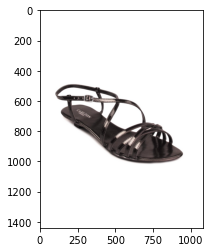

In [24]:
# Select an example product image:

# N.b. change this file path to location of your example image:
example_img_path = '../data/2610.jpg'

print('----- Selected Image: -----')
plt.imshow(cv2.imread(example_img_path))

----- Similar Images: -----
1/1 [==============================] - 0s 99ms/step


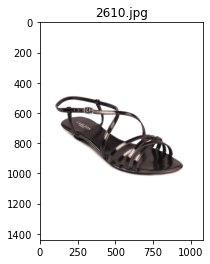

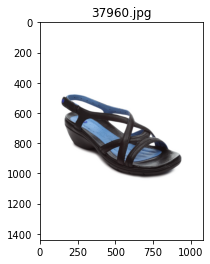

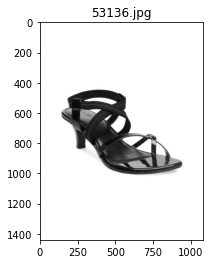

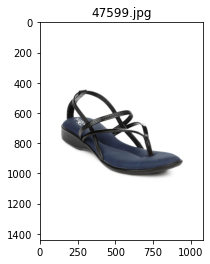

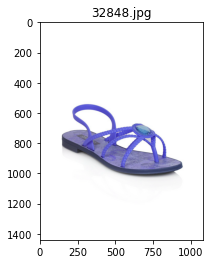

In [25]:
# Pass the test image to our prediction function and display the results:

print('----- Similar Images: -----')
display_similar_images(example_img_path)

## Conclusion:

Our function returned reasonably good results. The images closely resemble the input image we tested. However, it should be noted that our model doesn't always return good matches, and the results depend heavily on the size of the dataset we have indexed and stored in our database. For example, we have many images of clothing items in our dataset, but if a user searched selected an image of a bicycle as the input, the model would return very poor results since we don't have many bicycle images in our data. Therefore, it's important for our dataset to include the entire range of images that's applicable/relevant for our specific application.